# PROJET IML

## Données

In [1]:
# imports usuels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
import sklearn
%matplotlib inline

In [2]:
# import de la donnée
arr_pines = np.load("./data/indianapines.npy")
arr_salinas = np.load("./data/salinas.npy")

In [3]:
# import de la vérité terrain
arr_pines_gt = np.load("./data/indianapines_gt.npy")
arr_salinas_gt = np.load("./data/salinas_gt.npy")

Les images ont été récupérées avec un capteur faisant du : 400 μm (visible/bleu) jusqu'à 2500 μm (proche infrarouge), avec une largeur de bande de 10 nm.
Wikipedia donne :
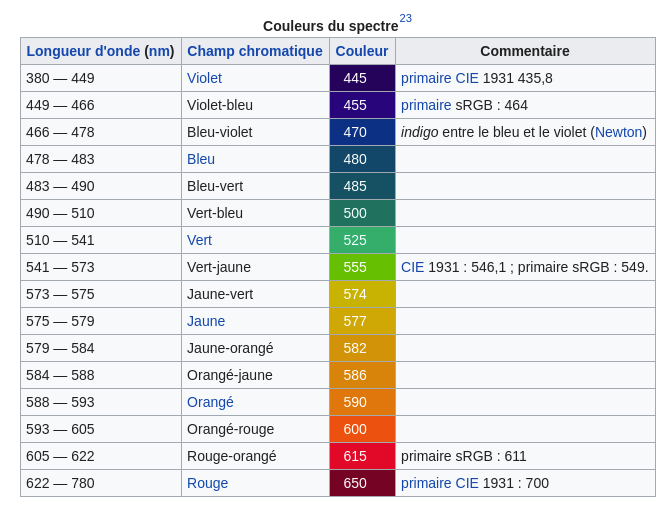

Il faut donc récupérer les longeurs d'ondes 464; 549 et 611 si l'on souhaite reconstruire l'image en RGB.

$$
\begin{align}
400 + 10 \times i &= \lambda\\
i &= \frac{\lambda - 400}{10}
\end{align}
$$

In [4]:
def find_index_wavelength(lambda_wl):
    return round((lambda_wl - 400) / 10)

In [5]:
def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

In [6]:
def rgb_arr(arr):
    r = find_index_wavelength(611)
    g = find_index_wavelength(549)
    b = find_index_wavelength(464)
    return arr[:,:,[r, g, b]]

Text(0.5, 1.0, 'Reconstruction RGB Salinas')

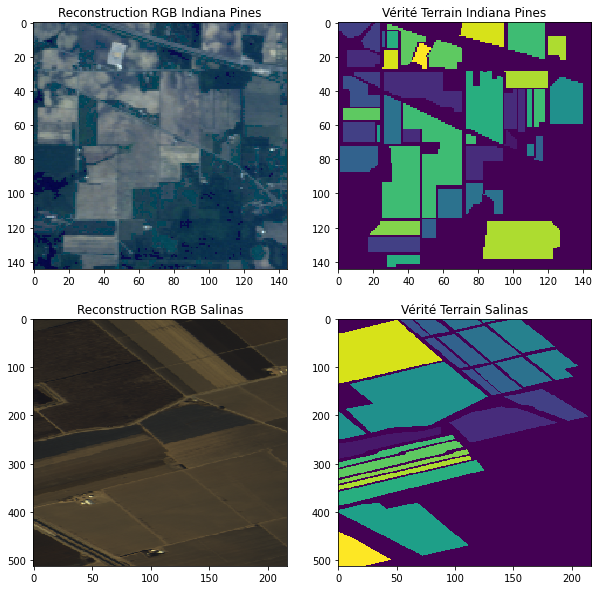

In [7]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs[0, 1].imshow(arr_pines_gt, cmap="viridis", aspect="auto", interpolation="none")
axs[1, 1].imshow(arr_salinas_gt, cmap="viridis", aspect="auto", interpolation="none")
axs[0, 1].set_title("Vérité Terrain Indiana Pines")
axs[1, 1].set_title("Vérité Terrain Salinas")

axs[0, 0].imshow(normalize(rgb_arr(arr_pines)), cmap="viridis", aspect="auto", interpolation="none")
axs[1, 0].imshow(normalize(rgb_arr(arr_salinas)), cmap="viridis", aspect="auto", interpolation="none")
axs[0, 0].set_title("Reconstruction RGB Indiana Pines")
axs[1, 0].set_title("Reconstruction RGB Salinas")

In [8]:
labels = ["Unknown", "Alfalfa", "Corn-notill", "Corn-mintill", "Corn", "Grass-pasture", "Grass-trees", 
          "Grass-pasture-mowed", "Hay-windrowed", "Oats", "Soybean-notill", "Soybean-mintill", "Soybean-clean",
          "Wheat", "Woods", "Building-Grass-Tree-Drives", "Stone-Steel-Towers"]

## Watershed segmentation

In [1411]:
arr = arr_salinas

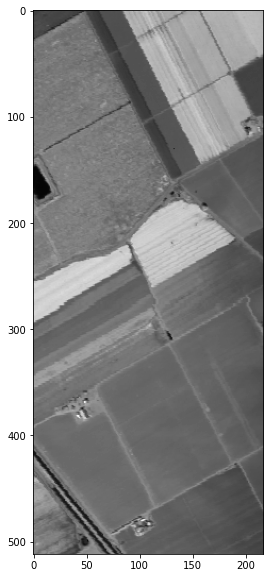

In [1412]:
img = arr[:,:,65]
plt.figure(figsize=(10,10))
plt.imshow(img, cmap="gray")

In [1413]:
from scipy import ndimage as ndi
from skimage.filters import rank
from skimage.morphology import ball, disk, square
from skimage.filters import sobel, roberts
from skimage.util import img_as_ubyte

In [1414]:
grad = np.zeros_like(arr[:,:,0], dtype="int64")

for i in range(arr.shape[2]):
    band = arr[:,:,i]
    band = img_as_ubyte(band)
    denoised = rank.median(band, square(2))
    gradient = rank.gradient(denoised, square(2))
    grad += gradient

In [1415]:
grad.min(), grad.max()

(0, 3169)

In [1416]:
grad = normalize(grad) * 255
# grad = skimage.morphology.closing(grad, selem=square(2))

(0.0, 255.0)

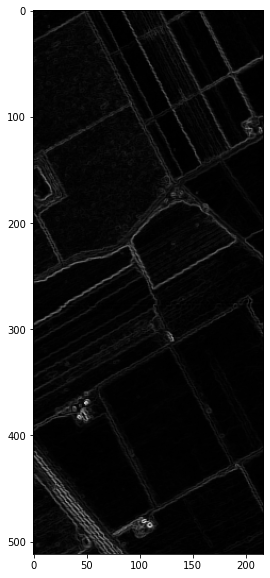

In [1417]:
plt.figure(figsize = (10,10))
plt.imshow(grad, cmap="gray")
grad.min(), grad.max()

In [1418]:
markers = grad < 40
markers = skimage.morphology.erosion(markers, selem=square(3))
markers = ndi.label(markers)[0]

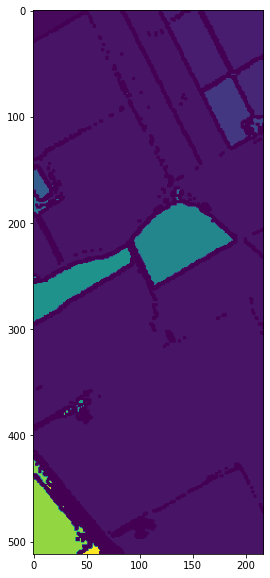

In [1419]:
plt.figure(figsize=(10,10))
plt.imshow(markers, cmap="viridis")

In [1420]:
from skimage.segmentation import watershed
wshed = watershed(grad)

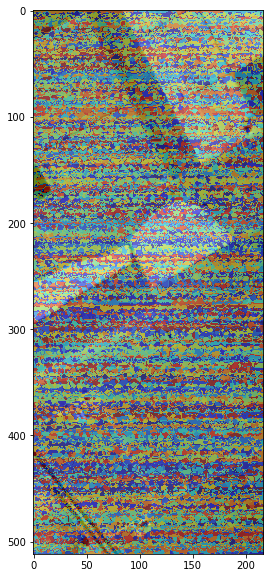

In [1421]:
import numpy as np
import matplotlib.pyplot as plt
vals = np.linspace(0,1,1000)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))



plt.figure(figsize=(10,10))
plt.imshow(img, cmap="gray")
plt.imshow(wshed, cmap=cmap, alpha=0.5)

In [1422]:
len(np.unique(out))

678

## Creation of train, test sets
We will first retrieve all the hyperspectral pixels and sort them according to their given class

In [1439]:
arr = np.copy(arr_salinas)
arr_gt = np.copy(arr_salinas_gt)

In [1440]:
# arr = np.resize(arr, (arr.shape[0], arr.shape[1], arr.shape[2] + 2))
indices = []
for i in range(arr.shape[0]):
    for j in range(arr.shape[1]):
        indices.append([i, j])
indices = np.array(indices)

In [1441]:
dim = arr.shape[2]
from sklearn.model_selection import train_test_split
X = arr.reshape((-1, dim))
y = arr_gt.reshape((-1))

X = np.column_stack([X, indices])

In [1442]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=42)

In [1443]:
np.round(np.unique(y_train, return_counts=True)[1] / (y_train.shape[0]) * 100)

array([51.,  2.,  3.,  2.,  1.,  3.,  3.,  3., 10.,  6.,  3.,  1.,  2.,
        1.,  1.,  7.,  2.])

In [1444]:
np.round(np.unique(y_test, return_counts=True)[1] / (y_test.shape[0]) * 100)

array([51.,  2.,  3.,  2.,  1.,  2.,  4.,  3., 10.,  6.,  3.,  1.,  2.,
        1.,  1.,  6.,  2.])

In [1445]:
X_train.shape, y_train.shape

((16665, 206), (16665,))

In [1446]:
X_train_indices = X_train[:,-2:]
X_test_indices = X_test[:, -2:]

In [1447]:
X_test_indices

array([[167, 196],
       [446,  72],
       [ 32,  36],
       ...,
       [  5, 201],
       [223,   7],
       [ 69,  86]])

In [1448]:
X_train = X_train[:,:-2]
X_test = X_test[:, :-2]

## With `DecisionTreeClassifier`

In [1449]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[('pca', sklearn.decomposition.PCA(n_components=5)),
                       ('clf', DecisionTreeClassifier())])

In [1450]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=5)),
                ('clf', DecisionTreeClassifier())])

In [1451]:
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     48538
           1       0.79      0.89      0.84      1545
           2       0.92      0.88      0.90      3319
           3       0.78      0.76      0.77      1725
           4       0.84      0.87      0.85      1155
           5       0.86      0.85      0.86      2268
           6       0.91      0.91      0.91      3378
           7       0.94      0.93      0.93      3107
           8       0.70      0.72      0.71      9214
           9       0.86      0.89      0.87      5098
          10       0.81      0.82      0.81      2741
          11       0.72      0.67      0.70       985
          12       0.81      0.87      0.84      1529
          13       0.82      0.75      0.78       852
          14       0.79      0.76      0.78       944
          15       0.62      0.59      0.61      6416
          16       0.93      0.88      0.91      1625

    accuracy              

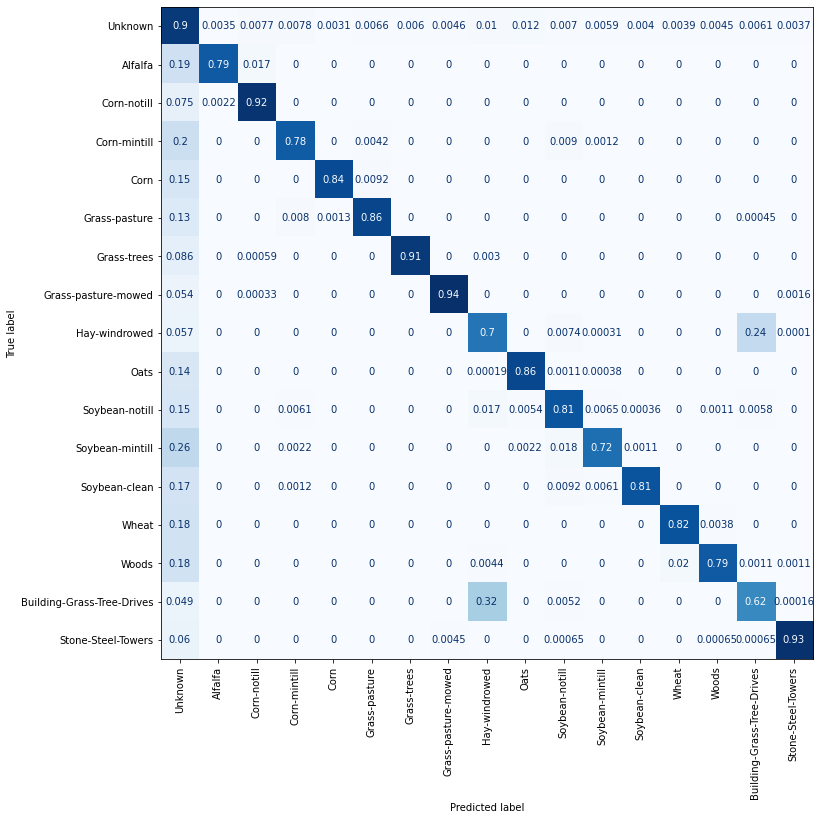

In [1461]:
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(pipe, X_test, y_test, ax=ax, display_labels=labels,
                      xticks_rotation="vertical",normalize="true",
                     colorbar=False, cmap="Blues")
y_predicted = pipe.predict(X_test)
print(classification_report(y_predicted, y_test))

## Rebuilding the image from X_train and X_test

In [1462]:
y = y.reshape(arr.shape[0], arr.shape[1])

In [1463]:
y_rebuilt = np.ones_like(y)
for i in range(len(y_test)):
    h, w = X_test_indices[i]
    y_rebuilt[h, w] = y_predicted[i]
for i in range(len(y_train)):
    h, w = X_train_indices[i]
    y_rebuilt[h, w] = y_train[i]

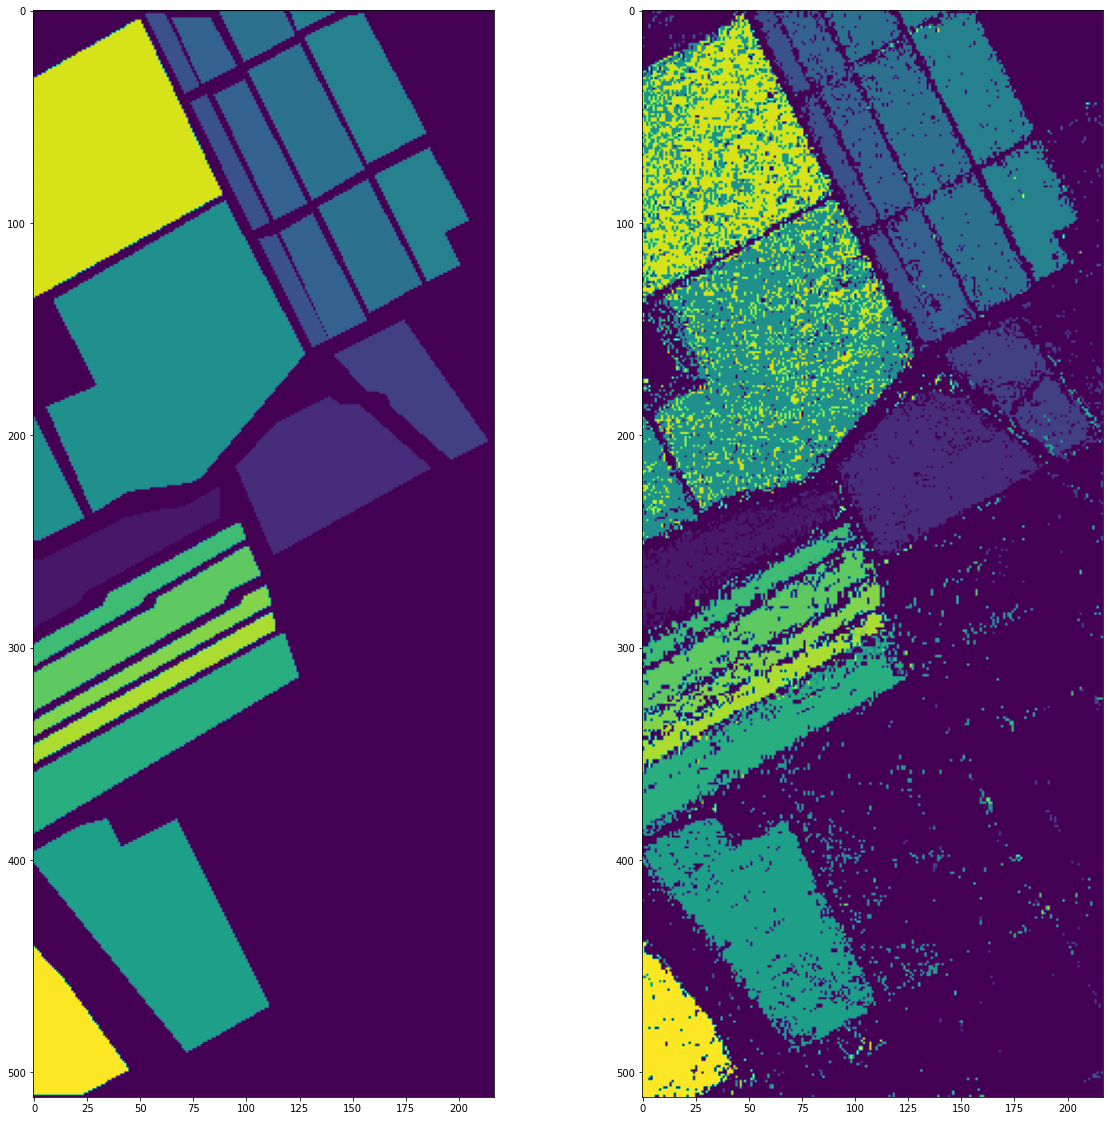

In [1464]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.imshow(y)
ax2.imshow(y_rebuilt)

Using the watershed patches, the image is reconstructed using a majority voting scheme

In [1456]:
patches = len(np.unique(wshed))
for patch in range(patches):
    ids, counts = np.unique(y_rebuilt[(wshed == patch)], return_counts=True)
    if (len(counts) != 0):
        y_rebuilt[(wshed == patch)] = ids[np.argmax(counts)]

In [1465]:
import skimage
from skimage.morphology import opening, closing

def sharpenResult(result):
    my_result = result.copy()
    for i in range(1, result.max() + 1):
        classResult = my_result == i
        my_result[classResult] = 0
        

        
        classResult = skimage.morphology.remove_small_objects(classResult, 12)
        
        classResult = skimage.morphology.remove_small_holes(classResult, 8)
        classResult = skimage.morphology.closing(classResult, skimage.morphology.square(5))
        classResult = skimage.morphology.opening(classResult, skimage.morphology.square(3))
        
        my_result[classResult] = i
    return my_result

In [1466]:
y_rebuilt = sharpenResult(y_rebuilt)

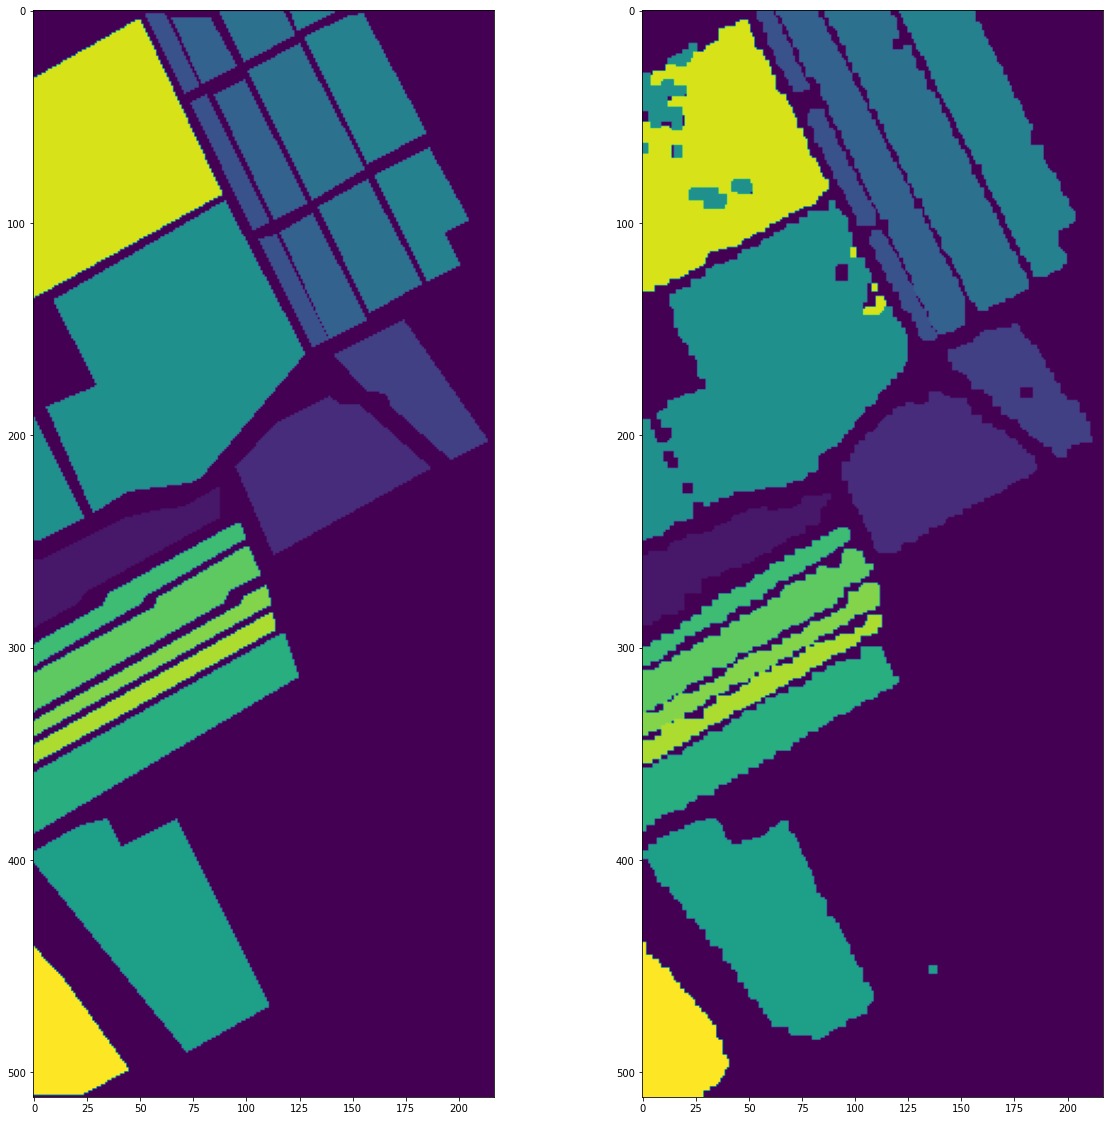

In [1467]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.imshow(y)
ax2.imshow(y_rebuilt)

## Extract back y_predicted from the y_rebuilt

In [1468]:
i = 0
for h, w in X_test_indices:
    y_predicted[i] = y_rebuilt[h, w]
    i += 1

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     47876
           1       0.93      0.93      0.93      1731
           2       0.99      0.91      0.95      3458
           3       0.93      0.94      0.93      1653
           4       0.87      0.92      0.89      1127
           5       0.96      0.88      0.92      2445
           6       0.98      0.90      0.94      3686
           7       0.98      0.89      0.94      3355
           8       0.96      0.92      0.94     10006
           9       0.95      0.99      0.97      5050
          10       0.91      0.97      0.94      2588
          11       0.83      0.92      0.87       829
          12       0.94      0.94      0.94      1642
          13       0.96      0.81      0.88       937
          14       0.91      0.85      0.88       977
          15       0.87      0.98      0.92      5439
          16       0.98      0.92      0.95      1640

    accuracy              

<AxesSubplot:>

<Figure size 1440x1440 with 0 Axes>

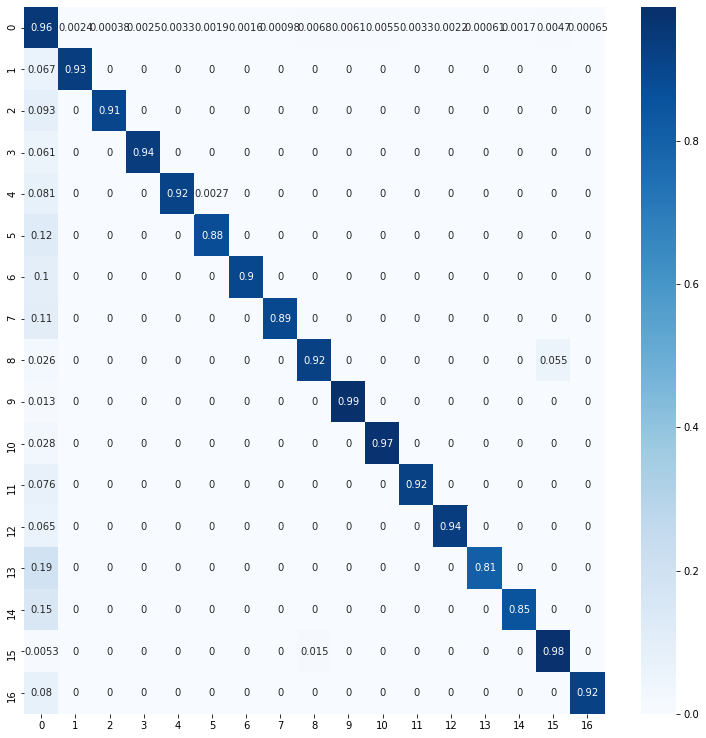

In [1469]:
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns


print(classification_report(y_predicted, y_test, zero_division=True))
matrix = confusion_matrix(y_predicted, y_test, normalize="true")
plt.figure(figsize=(20,20))

fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(matrix, annot=True, cmap='Blues',ax=ax)

## Dimension reduction

In [45]:
arr_pines_flat = arr_pines.reshape((-1, dim))
# X.reshape((row, col, dim)).shape

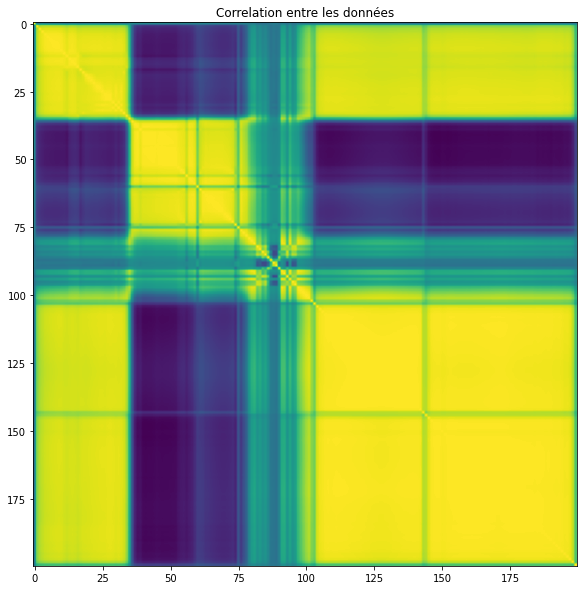

In [46]:
Sigma = np.corrcoef(arr_pines_flat,rowvar=False)
plt.figure(figsize=(10,10))
plt.title('Correlation entre les données')
plt.imshow(Sigma)

In [47]:
import sklearn.decomposition
pca_pines = sklearn.decomposition.PCA()
pca_pines.fit(arr_pines_flat)

PCA()

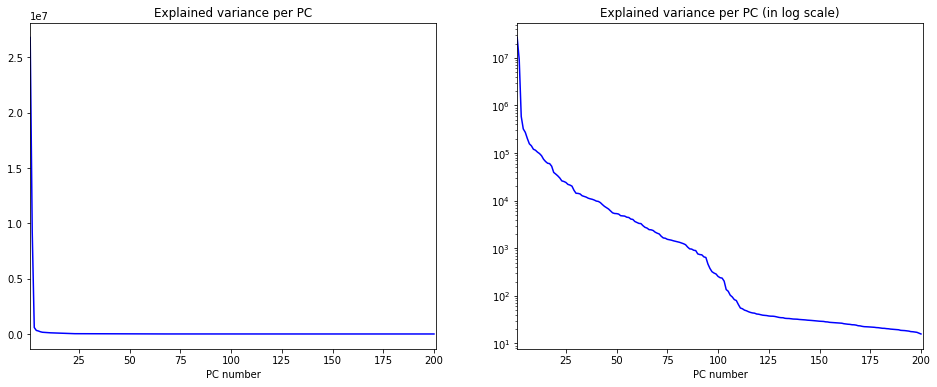

In [48]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title('Explained variance per PC')
plt.plot(np.arange(1,dim+1),pca_pines.explained_variance_,'b')
plt.xlabel('PC number')
plt.xlim(1,dim+1)
plt.subplot(122)
plt.title('Explained variance per PC (in log scale)')
plt.plot(np.arange(1,dim+1),pca_pines.explained_variance_,'b')
plt.xlabel('PC number')
plt.xlim(1,dim+1)
plt.yscale('log')
plt.show()

In [49]:
nb_comp = 10

In [53]:
pines_projected = pca_hsi.transform(arr_pines_flat)
pines_projected_small = pines_projected[:,:nb_comp].reshape((row,col,10))

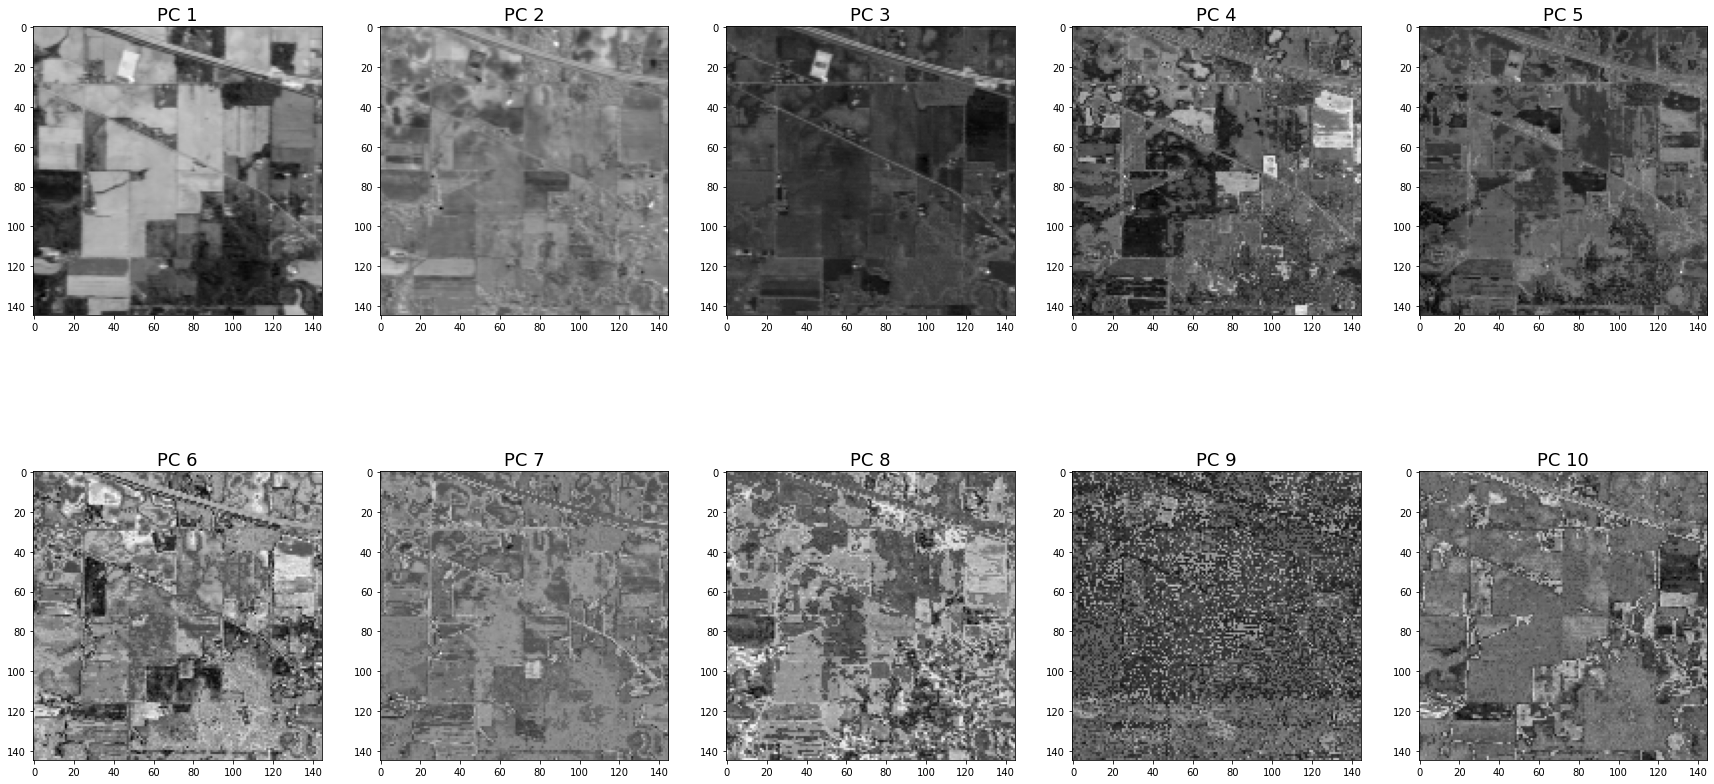

In [54]:
plt.figure(figsize=(30,15))
for i in range(nb_comp):
    plt.subplot(2,5,i+1)
    plt.title('PC %d'%(i+1),fontsize=18)
    plt.imshow(pines_projected_small[:,:,i],cmap='gray')
plt.show()

In [55]:
pines_projected_full = pines_projected.copy()
pines_projected_full[:,10:] = 0
pines_proj_back = pca_pines.inverse_transform(pines_projected_full).reshape((row,col,dim))

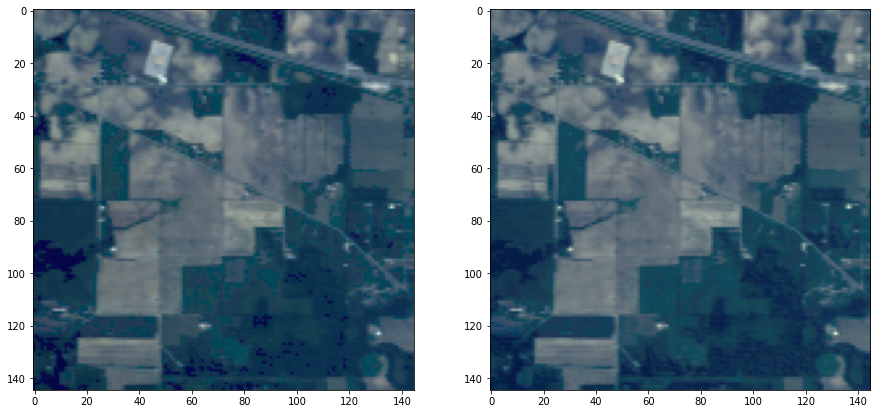

In [56]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(normalize(rgb_pines))
plt.subplot(122)
plt.imshow(normalize(pines_proj_back[:,:,[r, g, b]]))
plt.show()

In [60]:
pines_projected_small.shape

(145, 145, 10)